In [8]:
!pip install pyro-ppl
!pip install arviz
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.0 MB/s eta 0:00:00


In [221]:
import functools
import warnings

import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models import GPModel
from pyro.infer import MCMC, HMC, NUTS, Predictive
from pyro.distributions.constraints import positive

import arviz as az

from tqdm.notebook import tqdm

In [222]:
pyro.set_rng_seed(2401131782)
torch.set_default_dtype(torch.float64)

testing = False # TODO: set to False

In [223]:
# Constants
n_train = 20
n_test = 10
N = n_train + n_test
beta = 100
X = torch.linspace(0.0, 1.0, N) # grid of observations
l = 101
x_axis = torch.linspace(0.0, 1.0, l) # used for graphing

noise = torch.tensor(beta**-1)

In [224]:
# Function to learn
def g(x):
    return -(torch.sin(6*torch.pi*x))**2 + 6*x**2 - 5*x**4 + 3.0/2.0

In [225]:
# Utility functions for defining kernels
# Taken from
#  - https://docs.pyro.ai/en/stable/_modules/pyro/contrib/gp/kernels/kernel.html
#  - https://docs.pyro.ai/en/stable/_modules/pyro/contrib/gp/kernels/isotropic.html
def _torch_sqrt(x, eps=1e-12):
    """
    A convenient function to avoid the NaN gradient issue of :func:`torch.sqrt`
    at 0.
    """
    # Ref: https://github.com/pytorch/pytorch/issues/2421
    return (x + eps).sqrt()

def _square_scaled_dist(X, Z, lengthscale):
    r"""
    Returns :math:`\|\frac{X-Z}{l}\|^2`.
    """
    X = X.unsqueeze(1)
    Z = Z.unsqueeze(1)
    if X.size(1) != Z.size(1):
        raise ValueError("Inputs must have the same number of features.")

    scaled_X = X / lengthscale
    scaled_Z = Z / lengthscale
    X2 = (scaled_X**2).sum(1, keepdim=True)
    Z2 = (scaled_Z**2).sum(1, keepdim=True)
    XZ = scaled_X.matmul(scaled_Z.t())
    r2 = X2 - 2 * XZ + Z2.t()
    return r2.clamp(min=0)

def _scaled_dist(X, Z, lengthscale):
    r"""
    Returns :math:`\|\frac{X-Z}{l}\|`.
    """
    return _torch_sqrt(_square_scaled_dist(X, Z, lengthscale))

In [226]:
def rbf_kernel(X, Z, variance, lengthscale):
    r2 = _square_scaled_dist(X, Z, lengthscale)
    return variance * torch.exp(-0.5 * r2)

def cosine_kernel(X, Z, variance, lengthscale):
    r = _scaled_dist(X, Z, lengthscale)
    return variance * torch.cos(r)

def periodic_kernel(X, Z, variance, lengthscale, period):
    X = X.unsqueeze(1)
    Z = Z.unsqueeze(1)
    if X.size(1) != Z.size(1):
        raise ValueError("Inputs must have the same number of features.")

    d = X.unsqueeze(1) - Z.unsqueeze(0)
    scaled_sin = torch.sin(torch.pi * d / period) / lengthscale
    return variance * torch.exp(-2 * (scaled_sin**2).sum(-1))

# We choose a locally periodic kernel as the function
# we are fitting is (somewhat) periodic.
def kernel(X, Z, variance, lengthscale, period):
  k1 = periodic_kernel(X, Z, variance, lengthscale, period)
  k2 = rbf_kernel(X, Z, variance, lengthscale)
  return (k1 * k2) / variance

# We optimize the following parameters:
# kernel variance, kernel length, kernel period
params = ("var", "length", "period")

In [227]:
class Model():
    def __init__(self, noise):
        self.noise = noise

    def __call__(self, X, y=None):
        var    = pyro.sample("var",    dist.LogNormal(0.0, 1.0))
        length = pyro.sample("length", dist.LogNormal(0.0, 1.0))
        period = pyro.sample("period", dist.LogNormal(0.0, 1.0))

        eta = (var, length, period)
        # Compute the covariance with the chosen kernel
        cov = kernel(
            X, X,
            *eta
        )
        cov += self.noise * torch.eye(X.shape[0])

        # Sample predictive values as a gaussian.
        return pyro.sample(
            "y",
            dist.MultivariateNormal(loc=torch.zeros(X.shape[0]), covariance_matrix=cov),
            obs=y,
        )

In [228]:
def sample_data(X, n_train, n_test):
    N = n_train + n_test
    # Partition sample points
    idx = np.random.permutation(N)
    X = X[idx]
    # Sample y_i = g(x_i) + ϵ
    noise = dist.Normal(0.0, beta**-1).sample(sample_shape=(N,))
    y = g(X) + noise
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [229]:
def predict(kernel, X, y, X_pred, *params):
    N = X.shape[0]
    noise = params[0]
    eta = params[1:]
    # Follow simple GP algorithm from p. 40
    # of Oswin's notes.
    K_S =  kernel(X, X, *eta)
    K_Sx = kernel(X, X_pred, *eta)
    K_xx = kernel(X_pred, X_pred, *eta)
    G = torch.linalg.inv(noise * torch.eye(N) + K_S)
    a = torch.matmul(G, y)
    mustar = torch.matmul(K_Sx.T, a)
    Sigmastar = K_xx - torch.matmul(torch.matmul(K_Sx.T, G), K_Sx)
    return mustar, Sigmastar # return mean and covariance matrix

In [230]:
def log_likelihood(X, y, *params):
    noise = params[0]
    eta = params[1:]
    N = len(y)
    K_S = kernel(X, X, *eta)
    t1 = y.T @ torch.linalg.inv(noise * torch.eye(N) + K_S) @ y
    t2 = torch.log(torch.linalg.det(noise * torch.eye(N) + K_S))
    t3 = N * torch.log(torch.sqrt(2 * torch.tensor(torch.pi)))
    ll = -0.5 * (t1 + t2 + t3)
    return ll

In [231]:
def plot_data(ax, X_train, y_train, X_test, y_test, plot_g=True):
    ax.plot(X_train, y_train, 'kx', label='train')
    if len(X_test) > 0:
      ax.plot(X_test, y_test, 'k.', label='test')
    if plot_g:
        ax.plot(x_axis, g(x_axis), 'r-', label='g(x)')
    ax.legend()

In [232]:
def plot_prior_samples(ax, samples):
    N = len(x_axis)
    ax.plot(x_axis, samples.T, lw=2)

In [233]:
def plot_gaussian(ax, X, mean, cov, mean_label=None, sd_label=None):
    mean = mean.detach().numpy()
    sd = cov.diag().sqrt().detach().numpy()
    ax.plot(X, mean, "g", lw=2, label=mean_label)  # plot the mean
    ax.fill_between(
        X,  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd),
        (mean + 2.0 * sd),
        color="C0",
        alpha=0.3,
        label=sd_label,
    )

In [234]:
def plot_predictions(ax, X_train, y_train, X_test, y_test, X, mean, cov, plot_g=False):
    plot_data(
        ax=ax,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        plot_g=plot_g,
    )
    plot_gaussian(
        ax=ax,
        X=X,
        mean=mean,
        cov=cov,
        mean_label="GP prediction",
        sd_label="GP uncertainty",
    )

In [235]:
def plot_loss(ax, loss):
    ax.plot(loss)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

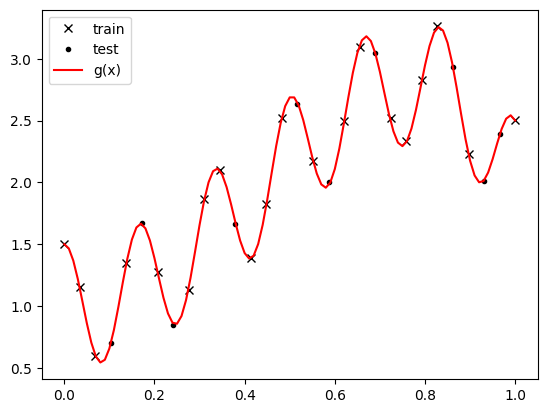

In [236]:
# Sample and plot the data
X_train, y_train, X_test, y_test = sample_data(X, n_train, n_test)
fig, ax = plt.subplots()
plot_data(ax, X_train, y_train, X_test, y_test)

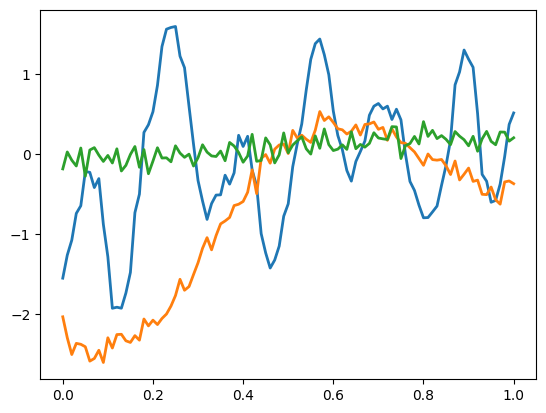

In [237]:
# Samples of unlearned GP
model = Model(noise)
samples = np.array([model(x_axis).detach().numpy() for _ in range(3)])
fig, ax = plt.subplots()
plot_prior_samples(ax, samples)

# Maximum a-posteriori estimate via gradient descent

In [238]:
def train_MAP(model, X_train, y_train, num_steps):
    pyro.clear_param_store()

    # Compute MAP estimate via gradient descent.
    guide=pyro.infer.autoguide.AutoDelta(model)
    optim=pyro.optim.Adam({"lr": 0.02})
    svi=pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

    losses = []
    for i in tqdm(range(num_steps), "MAP estimate"):
        loss = svi.step(X_train, y_train)
        losses.append(loss)

    # Extract learned parameters
    learned_params = [pyro.get_param_store()["AutoDelta." + param] for param in params]

    return learned_params, losses

In [239]:
map_num_steps = 2000 if not testing else 100

In [240]:
model = Model(noise)
learned_params, losses = train_MAP(
    model=model,
    X_train=X_train,
    y_train=y_train,
    num_steps=map_num_steps
)
print()
for param, value in zip(params, learned_params):
    print(f"{param}: {value}")

MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]


var: 2.1911308139011787
length: 0.7511570806329568
period: 0.6709109580278269


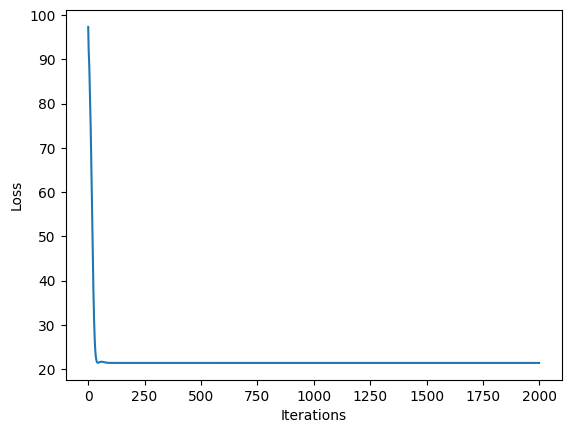

In [241]:
# Plot losses
fig, ax = plt.subplots()
plot_loss(ax, losses)

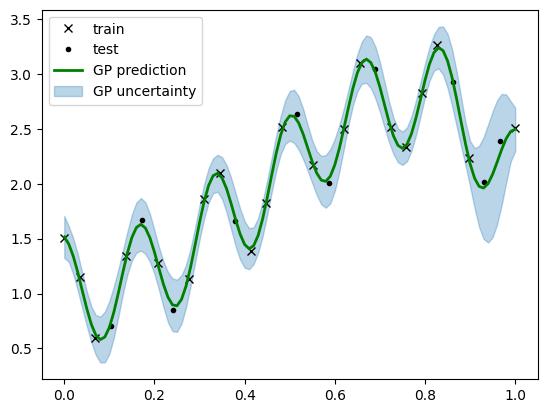

In [242]:
# Plot prediction
mean_pred, cov_pred = predict(kernel, X_train, y_train, x_axis, noise, *learned_params)

fig, ax = plt.subplots()
plot_predictions(
    ax=ax,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    X=x_axis, mean=mean_pred, cov=cov_pred,
)
ax.legend()

In [243]:
# Calculate the log-likelihood of the predictions on the test data
ll = log_likelihood(X_test, y_test, noise, *learned_params)
print(f"Log-likelihood of test samples: {ll}")

Log-likelihood of test samples: -12.985746931748661


# Sampling the posterior via NUTS

In [ ]:
def train_NUTS(model, X_train, y_train, warmup_steps, num_samples, num_chains):
    pyro.clear_param_store()
    idata = None

    # sequentially run chains, since backend mp_context is not working as expected. Parallel running broken for notebooks.
    for _i in range(num_chains):
        nuts_kernel = NUTS(
            model=model,
            jit_compile=True
        )
        mcmc = MCMC(
            nuts_kernel,
            num_samples=num_samples,
            warmup_steps=warmup_steps,
            num_chains=1,
            mp_context=None,
        )
        mcmc.run(X_train, y_train)
        if idata == None:
            idata = az.from_pyro(mcmc)
        else:
            idata_i = az.from_pyro(mcmc)
            idata = az.concat(idata, idata_i, dim="chain")

    # Extract posterior parameter samples
    posterior_samples = [torch.tensor(idata.posterior[param].data).flatten() for param in params]

    return posterior_samples, idata

In [ ]:
# Hyper-parameters for learning
nuts_warmup_steps = 1500 if not testing else 20
nuts_num_samples = 500 if not testing else 10
nuts_num_chains = 4 if not testing else 1

In [ ]:
model = Model(noise)
posterior_samples, idata = train_NUTS(
    model=model,
    X_train=X_train, y_train=y_train,
    warmup_steps=nuts_warmup_steps,
    num_samples=nuts_num_samples,
    num_chains=nuts_num_chains,
)

idata

Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
length  0.979  0.283   0.365    1.473      0.115    0.086       7.0      21.0   
period  0.671  0.678   0.474    1.112      0.162    0.117       7.0      22.0   
var     3.673  2.212   1.027    7.442      0.142    0.101     288.0     290.0   

        r_hat  
length   1.53  
period   1.56  
var      1.02  


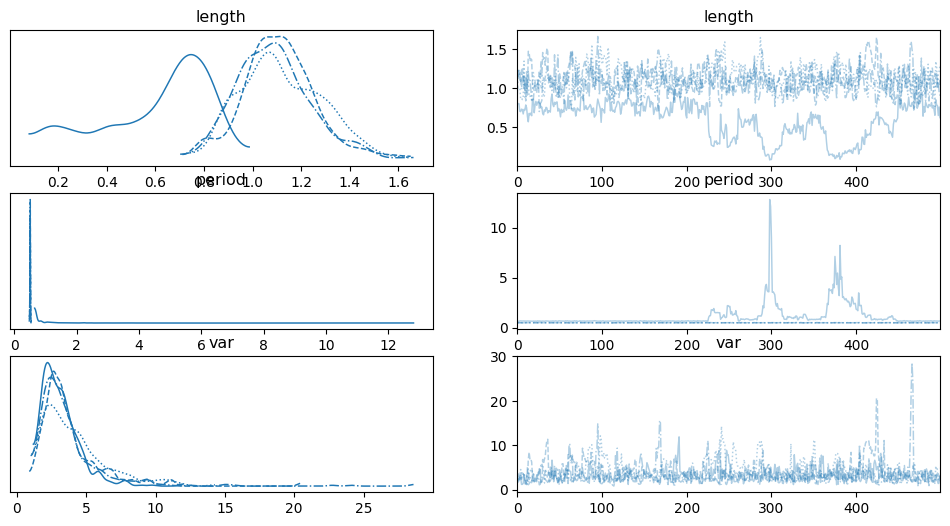

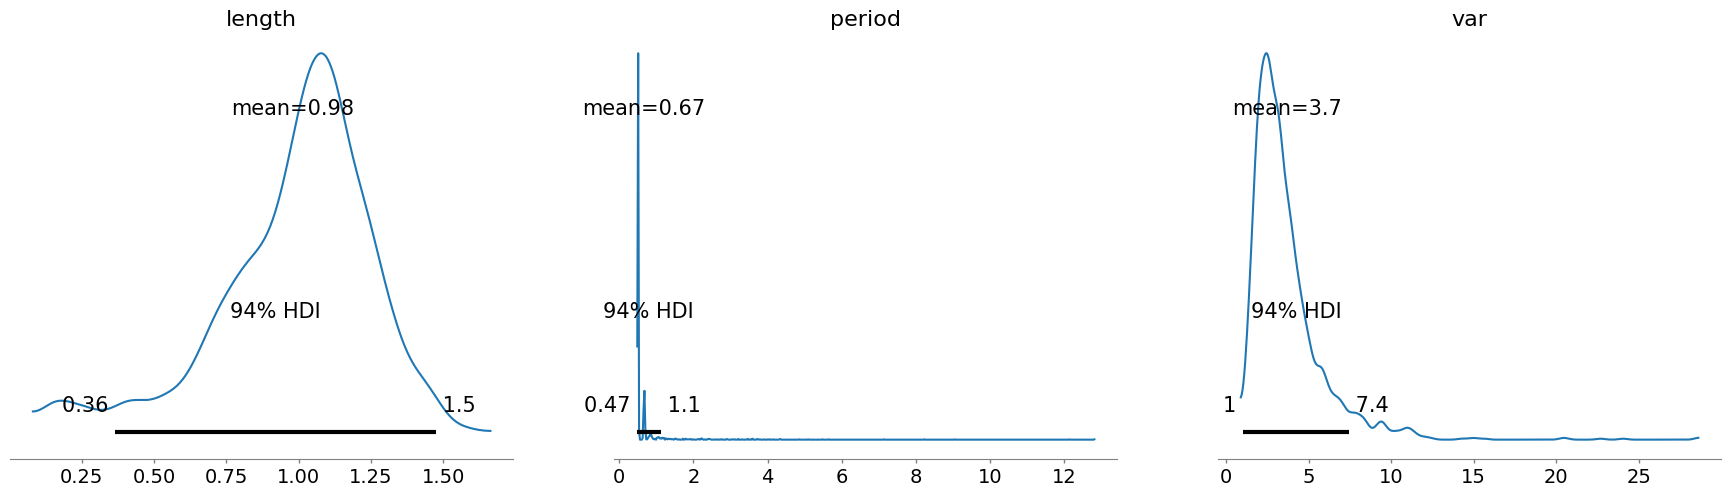

In [ ]:
# inspect the sampled data
summary = az.summary(idata)
print(summary)
az.plot_trace(idata)
plt.show()
az.plot_posterior(idata)
plt.show()

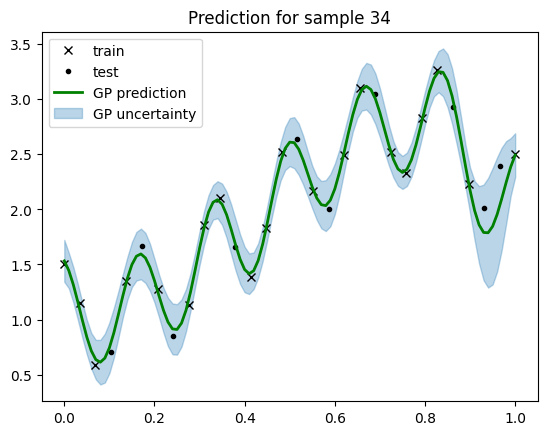

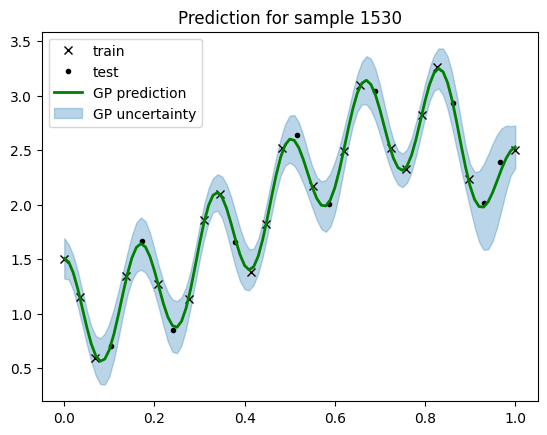

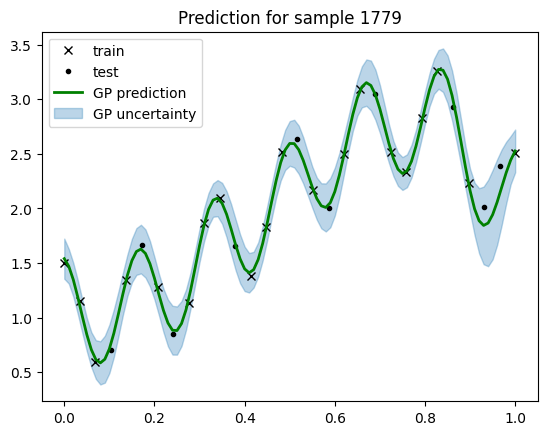

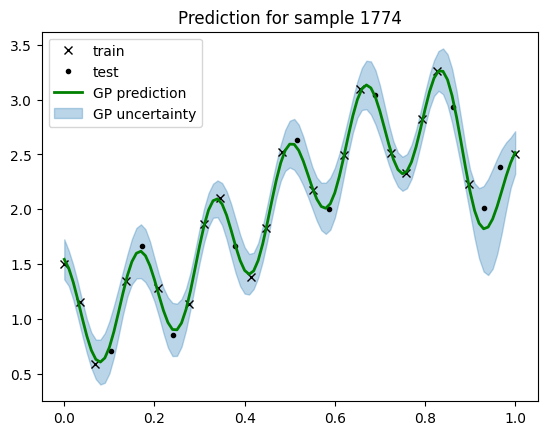

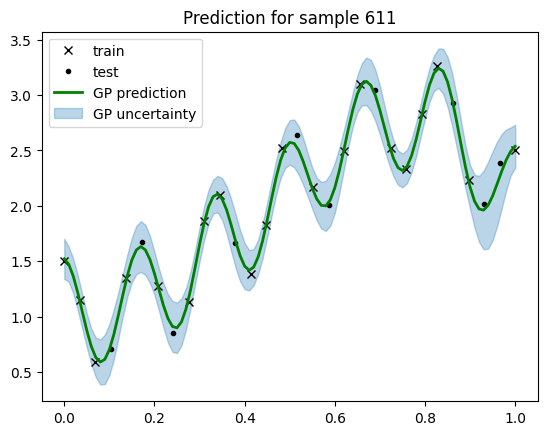

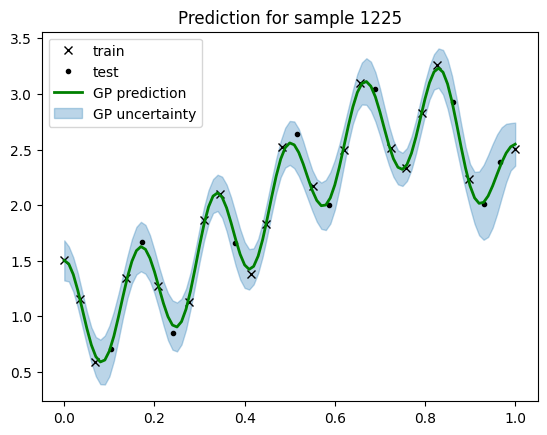

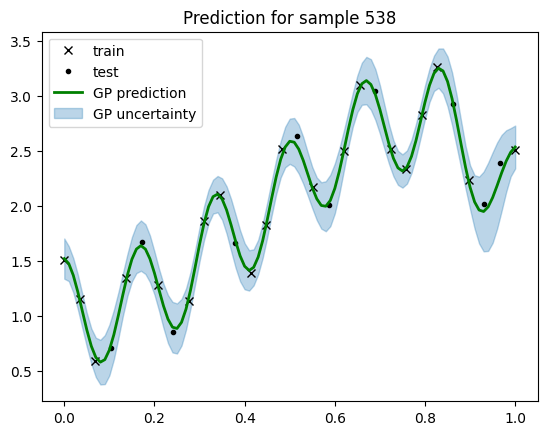

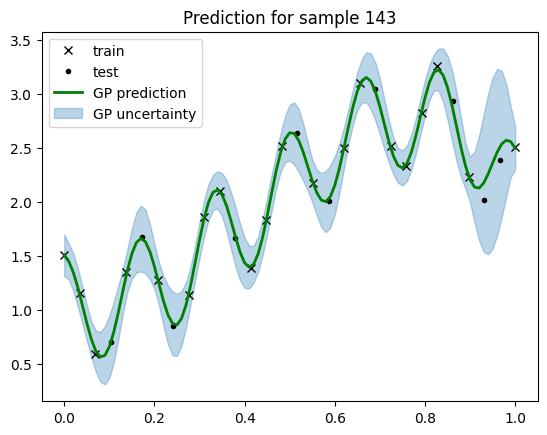

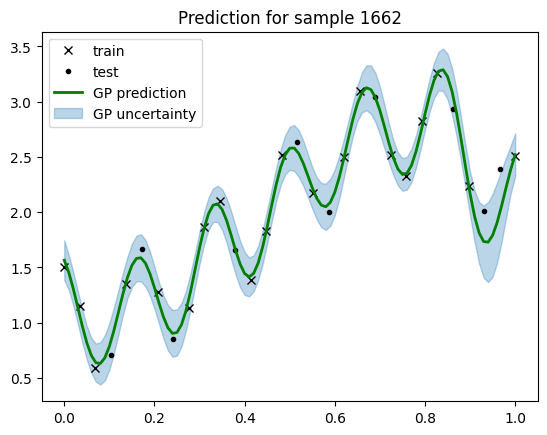

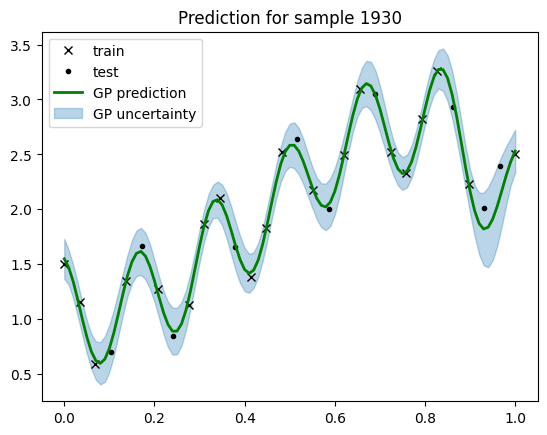

In [ ]:
mean_preds, cov_preds = torch.vmap(
    lambda params: predict(
        kernel, X_train, y_train, x_axis, noise, *params,
    )
)(posterior_samples)

idxs = torch.randint(nuts_num_samples*nuts_num_chains, size=(10,))
for i in range(10):
    j = int(idxs[i])
    fig, ax = plt.subplots()
    mean_pred = mean_preds[j]
    cov_pred = cov_preds[j]
    plot_predictions(
        ax=ax,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        X=x_axis, mean=mean_pred, cov=cov_pred,
    )
    ax.legend()
    ax.set_title("Prediction for sample {}".format(j))

In [ ]:
# Calculate the log-likelihood of the averaged sampled data
log_likelihoods = torch.vmap(
    lambda params: log_likelihood(X_test, y_test, noise, *params)
)(posterior_samples)

NUTS log-likelihoods mean = -11.817279745632776 and variance = 1.7656329254904972


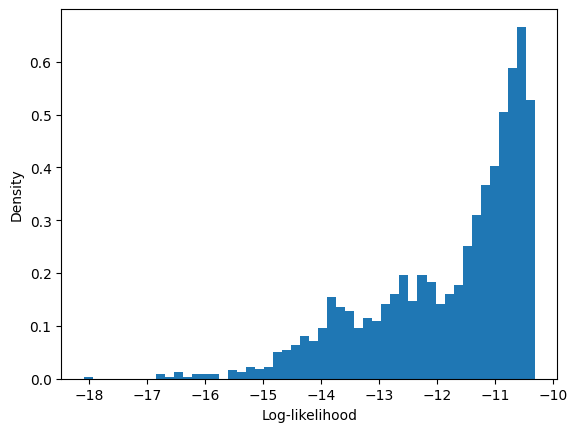

In [ ]:
print("NUTS log-likelihoods mean = {1} and variance = {0}".format(*torch.var_mean(log_likelihoods)))
fig, ax = plt.subplots()
ax.set_ylabel('Density')
ax.set_xlabel('Log-likelihood')
ax.hist(log_likelihoods.detach().numpy(), bins=50, density=True)
plt.show()

## Comparing MAP estimate and NUTS sampling

In [ ]:
n_iters = 20 if not testing else 5
nuts_num_chains=1 # Otherwise it takes too long

log_likelihoods_map = []
log_likelihoods_nuts = []
for i in range(n_iters):
    print(f"Iteration {i+1}/{n_iters}")
    X_train, y_train, X_test, y_test = sample_data(X, n_train, n_test)

    # Calculate log-likelihood of MAP estimate
    print("Training MAP model...")
    model = Model(noise)
    learned_params, losses = train_MAP(
        model=model,
        X_train=X_train,
        y_train=y_train,
        num_steps=map_num_steps
    )
    ll_map = log_likelihood(X_test, y_test, noise, *learned_params)
    log_likelihoods_map.append(ll_map)
    print("MAP estimate log-likelihood = {0}".format(ll_map))

    # Calculate log-likelihood of NUTS sampling
    print("Training NUTS model...")
    model = Model(noise)
    posterior_samples, idata = train_NUTS(
        model=model,
        X_train=X_train, y_train=y_train,
        warmup_steps=nuts_warmup_steps,
        num_samples=nuts_num_samples,
        num_chains=nuts_num_chains,
    )

    mean_preds, cov_preds = torch.vmap(
        lambda params: predict(
            kernel,
            X_train, y_train, X_test,
            noise, *params,
        )
    )(posterior_samples)

    ll_nuts = torch.vmap(
        lambda params: log_likelihood(X_test, y_test, noise, *params)
    )(posterior_samples)

    log_likelihoods_nuts.append(ll_nuts)
    print("NUTS log-likelihoods mean = {1} and variance = {0}".format(*torch.var_mean(ll_nuts)))

log_likelihoods_map  = torch.tensor(log_likelihoods_map)
log_likelihoods_nuts = torch.cat(log_likelihoods_nuts)

Iteration 1/20
Training MAP model...


<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -20.163287446266075
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.894434480584085 and variance = 0.6795275317115418
Iteration 2/20
Training MAP model...


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -6.110872073549425
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -6.834058108262213 and variance = 0.6104763541032812
Iteration 3/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -8.92291840457602
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.495149842784526 and variance = 0.7194469956689676
Iteration 4/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -8.801873553145782
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.530299035267413 and variance = 0.5016906566199483
Iteration 5/20
Training MAP model...


<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -7.909989971103925
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.838346673182219 and variance = 0.5173552473024204
Iteration 6/20
Training MAP model...


/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -7.75931462912341
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.272505842941849 and variance = 0.2987971915707814
Iteration 7/20
Training MAP model...


/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -10.283785605454991
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.325271178877468 and variance = 0.6551629954284218
Iteration 8/20
Training MAP model...


/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -7.947132396766691
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -21.913349934184062 and variance = 63.43359196145259
Iteration 9/20
Training MAP model...


<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -8.747971207168774
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -12.610663794421 and variance = 1.6846038419234723
Iteration 10/20
Training MAP model...


<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -7.909371607712325
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.32355714795324 and variance = 0.23697884219435805
Iteration 11/20
Training MAP model...


<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -11.05374314813864
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -10.278571311736433 and variance = 0.38185446552852365
Iteration 12/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -9.785444315100008
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -10.048968497778688 and variance = 0.9435615114050455
Iteration 13/20
Training MAP model...


/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -5.06641759488921
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -3.045944604251051 and variance = 0.7206752543231247
Iteration 14/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -10.003040220415551
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -9.538979936333886 and variance = 0.35490077621307725
Iteration 15/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -10.870886893316797
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -10.314863016251593 and variance = 0.48009801518128403
Iteration 16/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -12.617855526645764
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.683429190714955 and variance = 1.4817194190380276
Iteration 17/20
Training MAP model...


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -11.42501085739263
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -8.685282114707752 and variance = 0.47447981352529445
Iteration 18/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -10.80448487781704
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -11.377317751547011 and variance = 0.513721773747157
Iteration 19/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -12.343672884124803
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -12.451936702966686 and variance = 2.59277188936655
Iteration 20/20
Training MAP model...



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
<ipython-input-19-8dff455500dd>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_steps), "MAP estimate"):


MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]

MAP estimate log-likelihood = -10.11887473089051
Training NUTS model...


Warmup:   0%|          | 0/2000 [00:00, ?it/s]<ipython-input-8-46e0f8b905aa>:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  noise  = pyro.param("noise", torch.tensor(beta**-1), constraint=positive)
<ipython-input-7-09c7ad6363fc>:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
<ipython-input-6-9eec615db6c1>:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a 

NUTS log-likelihoods mean = -9.219647310332496 and variance = 1.1133775350846258



/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


ValueError: only one element tensors can be converted to Python scalars

MAP  log-likelihoods mean = -9.93229739717992 and variance = 9.570349098861124
NUTS log-likelihoods mean = -9.73412882375387 and variance = 15.597409205451191


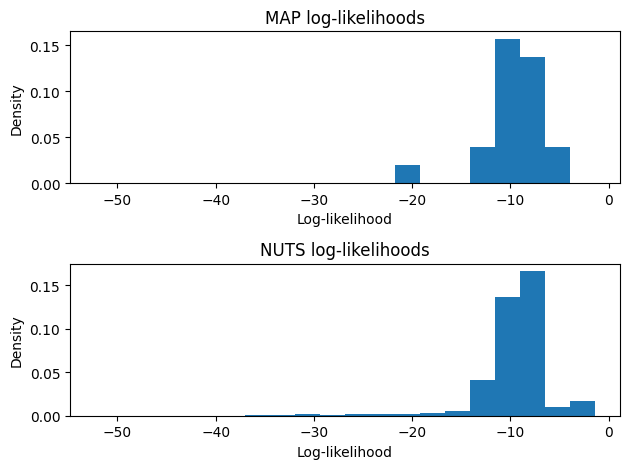

In [ ]:
print("MAP  log-likelihoods mean = {1} and variance = {0}".format(*torch.var_mean(log_likelihoods_map)))
print("NUTS log-likelihoods mean = {1} and variance = {0}".format(*torch.var_mean(log_likelihoods_nuts)))
n_bins = 20

ll_min = min(log_likelihoods_map.min(), log_likelihoods_nuts.min()).detach().numpy()
ll_max = max(log_likelihoods_map.max(), log_likelihoods_nuts.max()).detach().numpy()
fig, (ax1, ax2) = plt.subplots(2)
# MAP log-likelihood plot
ax1.set_title("MAP log-likelihoods")
ax1.set_ylabel('Density')
ax1.set_xlabel('Log-likelihood')
ax1.hist(
    log_likelihoods_map.detach().numpy(),
    range=(ll_min, ll_max),
    bins=n_bins,
    density=True
)
# NUTS log-likelihood plot
ax2.set_title("NUTS log-likelihoods")
ax2.set_ylabel('Density')
ax2.set_xlabel('Log-likelihood')
ax2.hist(
    log_likelihoods_nuts.detach().numpy(),
    range=(ll_min, ll_max),
    bins=n_bins,
    density=True
)
fig.tight_layout()

plt.show()

# Learning with integral constraints

In [244]:
# We train a fresh model
model = Model(noise)
learned_params, losses = train_MAP(
    model=model,
    X_train=X_train,
    y_train=y_train,
    num_steps=map_num_steps
)
print()
for param, value in zip(params, learned_params):
    print(f"{param}: {value}")

kernel_params = learned_params

MAP estimate:   0%|          | 0/2000 [00:00<?, ?it/s]


var: 2.1911308139011716
length: 0.751157080632956
period: 0.6709109580278266


Compute the mean and covariance of the distribution
$f|X,\hat{q}$.

In [245]:
def cond_prob_dist(kernel, q, X, noise, *kernel_params):
    l = X.shape[0]

    # Weight vector
    w = torch.tensor(
        [1.0/(2*l-2) if i == 0 or i == l-1 else 1.0/(l-1) for i in range(l)]
    ).reshape((1,l))
    # Stack `w` on top of identity matrix
    Q = torch.vstack((w, torch.eye(l)))
    # Kernel matrix
    K = kernel(X, X, *kernel_params)

    # Covariance of (q, f)|X
    S = Q @ K @ Q.T
    # Split into four blocks
    S11 = S[0,0].reshape((1,1))
    S12 = S[0,1:].reshape((1,l))
    S21 = S[1:,0].reshape((l,1))
    S22 = S[1:,1:].reshape((l,l))
    # Compute mean(s) and covariance
    mean = S21 @ torch.linalg.inv(S11) * q
    cov = S22 - S21 @ torch.linalg.inv(S11) @ S21.T

    mean = mean.flatten()

    return mean, cov

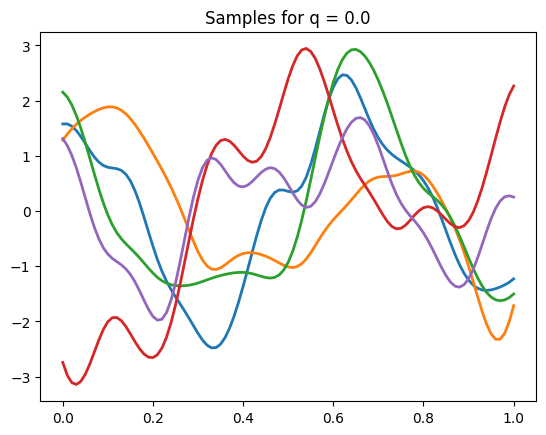

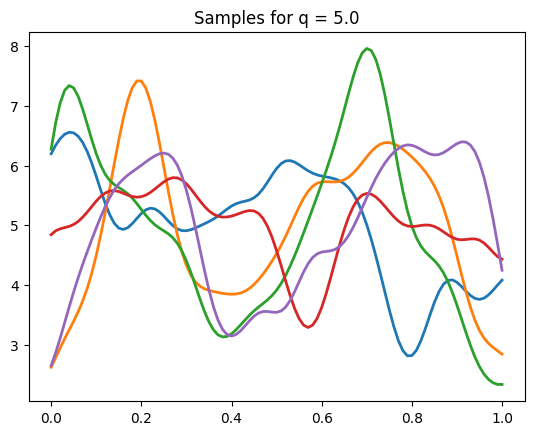

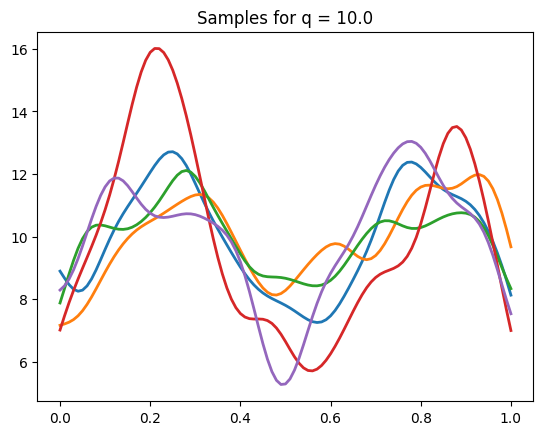

In [246]:
qs = torch.tensor([0.0,5,10])
# for each value of `q`, plot five samples.
for q in qs:
    mean, cov = cond_prob_dist(kernel, q, x_axis, noise, *kernel_params)
    y = scipy.stats.multivariate_normal(
        mean.detach().numpy().flatten(),
        cov.detach().numpy(),
        allow_singular=True,
    ).rvs(size=5)
    fig, ax = plt.subplots()
    plot_prior_samples(ax, y)
    ax.set_title(f"Samples for q = {q}")

We consider a new dataset $\mathcal{D} = \{ (0,1.46), (0.25, 0.93), (0.5, 2.76) \}$.

In [251]:
D = [(0, 1.46), (0.25, 0.93), (0.5, 2.76)]
X_train = torch.tensor([d[0] for d in D])
y_train = torch.tensor([d[1] for d in D])

Plot unconstrained predictions $f | \mathcal{D}$.

Mean of unconstrained prediction:  tensor(1.1525, grad_fn=<MeanBackward0>)


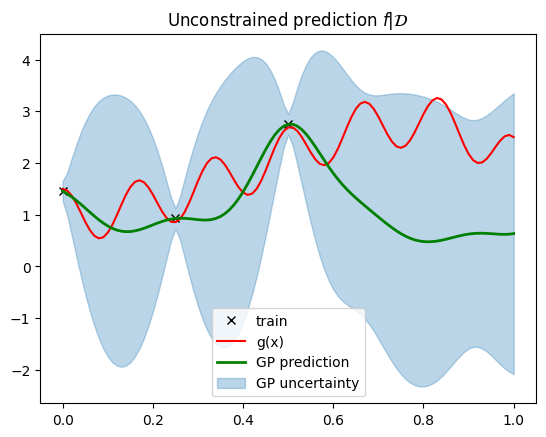

In [256]:
mean_pred, cov_pred = predict(
    kernel,
    X_train, y_train,
    x_axis, noise,
    *learned_params
)
print("Mean of unconstrained prediction: ", mean_pred.mean())

fig, ax = plt.subplots()
plot_predictions(
    ax=ax,
    X_train=X_train, y_train=y_train,
    X_test=[], y_test=[],
    X=x_axis, mean=mean_pred, cov=cov_pred,
    plot_g=True,
)
ax.legend()
ax.set_title("Unconstrained prediction $f | \mathcal{D}$")
plt.show()

Plot constrained predictions $f | \hat{q}=2, \mathcal{D}$.

In [257]:
def predict_cond(kernel, q, X, y, X_pred, *params):
    Z = torch.cat((X, X_pred))
    l = Z.shape[0]

    N = X.shape[0]
    noise = params[0]
    eta = params[1:]

    # Instead of using the normal kernel,
    # we use the mean an covariance of the constrained posterior
    mean, cov = cond_prob_dist(kernel, q, Z, noise, *eta)
    mean_S, mean_x = mean[:N], mean[N:]
    # Which we then split up as in the GP algorithm from p. 40 of Oswin's notes.
    K_S  = cov[0:N,0:N]
    K_Sx = cov[0:N,N:]
    K_xx = cov[N:,N:]

    G = torch.linalg.inv(noise * torch.eye(N) + K_S)
    # Here we remember to subtract the mean of the data points
    a = torch.matmul(G, (y - mean_S))

    # and add the mean of the prediction points
    mustar = mean_x + torch.matmul(K_Sx.T, a)
    Sigmastar = K_xx - torch.matmul(torch.matmul(K_Sx.T, G), K_Sx)

    return mustar, Sigmastar # return mean and covariance matrix

Mean of constrained prediction:  tensor(2.0039, grad_fn=<MeanBackward0>)


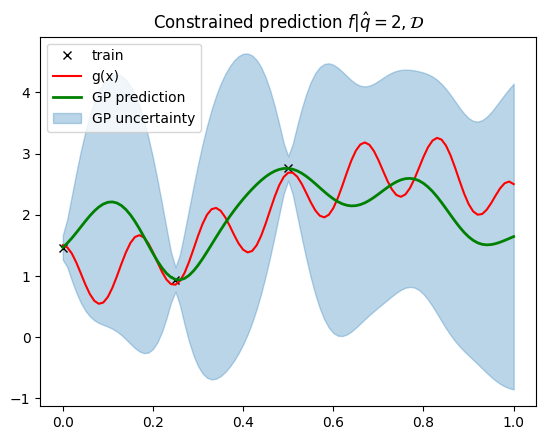

In [258]:
q = 2

mean_pred, cov_pred = predict_cond(
    kernel, q,
    X_train, y_train,
    x_axis, noise,
    *learned_params
)
print("Mean of constrained prediction: ", mean_pred.mean())

fig, ax = plt.subplots()
plot_predictions(
    ax=ax,
    X_train=X_train, y_train=y_train,
    X_test=[], y_test=[],
    X=x_axis, mean=mean_pred, cov=cov_pred,
    plot_g=True,
)
ax.legend()
ax.set_title("Constrained prediction $f | \hat{q}=2, \mathcal{D}$")
plt.show()